This notebook can be found on https://github.com/RaphaelMaser/Ray_Tune or opened in colab with the button below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RaphaelMaser/Ray_Tune/blob/main/Ray_Tune_FashionMNIST.ipynb)

![ray_header_logo_500px.png](images/ray_header_logo_500px.png)

*Ray Logo (https://docs.ray.io/en/latest/index.html)*

## Ray

Ray is a framework for distributed computing in Python. The core idea of Ray is to make distributed computing as accessible as possible while not disturbing the workflow of the user. For that purpose it integrates well with all of the mainstream Python libraries used in distributed scenarios like PyTorch, Tensorflow, Scikit-learn, etc.. Integrating Ray in your own workflow typically only needs small changes in your code, there is no need to re-write your application.

In general Ray consists of several different libraries:

![what-is-ray-padded_1200px.png](images/what-is-ray-padded_1200px.png)

*Ray Framework Overview (https://docs.ray.io/en/latest/index.html)*

Ray Core provides the capability to build clusters and distribute any workload across the nodes of the cluster. Whether that be your PC and laptop or some gpu nodes of the iris-HPC. Ray schedules the tasks across the nodes and manages data transfers between the nodes.

Ray Core is a low-level library and although it is well made it needs some knowledge to use it for more sophisticated tasks like hyperparameter optimization (HPO) or NN training. Ray's higher-level libraries like Ray Train (NN training) and Ray Tune (HPO) use the Ray Core library to provide a simple interface for interacting with Ray without needing to know the details of distributed training.

With Ray Tune only a few lines of code needs to be added to the training procedure to run a full HPO with state-of-the-art search algorithms and schedulers.

### Why should I use Ray Tune and not one of the other HPO libraries?

![tune_overview_600px.png](images/tune_overview_600px.png)


*Ray Framework Overview (https://docs.ray.io/en/latest/tune/index.html)*

Ray Tune itself provides a rich library of state-of-the-art algorithms for HPO. It furthermore integrates well with existing hyperparameter search libraries like optuna or hyperopt. The advantage in using Ray Tune for that purpose is twofold.

Ray Tune and the integrated libraries provide a wide range of algorithms. If you use Tune and want to change between different HPO libraries you don't need to rewrite any code, just change the search algorithm. If you would not use Tune a change between libraries would probably lead to rewriting some of the training code to match the requierements of the new library.

Ray provides a high degree of scalability. The trials are running concurrently on your machine and ressources of each trial can be easily managed (basically a one-liner). If you are training a complex model with huge datasets you can easily scale the workload across several nodes on the HPC. Scaling the workload from one node on the HPC to a whole cluster of nodes on the HPC requires a minimum of effort. 

Therefore if you are not sure whether you want to use the distributed capabilities of Ray or not I would recommend it. Even without the need for distributed computations it provides a great framework for HPO and if you decide that you need to scale the workload it can be done easily. But using the distributed capabilities of Ray really makes sense in most medical imaging situations. Even if you use only one node on the HPC it still provides 4 gpus. If we would do HPO search on this node using standard PyTorch without Ray we could probably use the DistributedDataParallel class to use all 4 gpus for the training of the model. This would probably create overhead because PyTorch needs to synchronize the state of the model across the gpus. Since HPO always needs some useful number of trails (probably higher than 4) we could also use Ray to train for models in parallel on the node to avoid this communication overhead.

## Defining a simple Neural Network for the FashionMNIST Dataset in PyTorch

Here the usage of HPO using Ray Tune is demonstrated on the FashionMNIST dataset with a simple NN. First we need to install the required dependencies and import all needed classes.

In [1]:
!pip install -q ray[tune]==2.2.0
!pip install -q torch==1.13.1 torchvision==0.14.1
!pip install -q matplotlib==3.6.2

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split
from matplotlib import pyplot as plt

from ray import tune, air
from ray.air import session
import ray
import os
from ray.tune.schedulers import ASHAScheduler
from ray.air import Checkpoint
from ray.tune.schedulers import PopulationBasedTraining

Afterwards we need to download the FashionMNIST dataset and create a PyTorch dataset from that. Luckily PyTorch can automatically download the dataset if it is not found in the directory. Afterwards we create two dataloaders, one for training and one for validation. In this example we split the official train set from FashionMNIST in a two parts for that purpose. The validation set will be used to search for good hyperparameter combinations and validate the model during training. The test dataset from FashionMNIST could be used afterwards to compare the network with the standard parameters and the models optimized with HPO. 

In [3]:
%%capture
# Download training data from open datasets.
data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

batch_size = 256

# Split the train set and create data loaders
train_data, val_data = random_split(data, [0.8,0.2])
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

The model used for the demonstration is a very simple fully connected network with 3 layers.

In [4]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We use a standard PyTorch training routine for the model. It would also be possible to use PyTorch Ignite or Lightning to avoid boilerplate code or use even other machine learning frameworks like Tensorflow or Keras.

In [5]:
# Standard PyTorch training routine
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct*100


The train() function iterates through the epochs and executes the train_epoch() function in every step. Furthermore it uses the test() function to test the model with the data in val_dataloader and show the current accuracy. For the training we use SGD with a learning rate of 1e-4 and a weight decay of 1e-5.

In [6]:
# Small function which iterates through the epochs
def train(epochs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-03, weight_decay=1e-05)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_epoch(train_dataloader, model, loss_fn, optimizer, device)
        test(val_dataloader, model, loss_fn, device)

# Start the training
train(10)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 27.4%, Avg loss: 2.280520 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 33.9%, Avg loss: 2.262501 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 36.1%, Avg loss: 2.243485 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 38.2%, Avg loss: 2.222186 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 40.1%, Avg loss: 2.197791 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 41.4%, Avg loss: 2.169705 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 42.0%, Avg loss: 2.137477 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 42.1%, Avg loss: 2.100362 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 42.2%, Avg loss: 2.057903 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 42.5%, Avg loss: 2.009689 



## Hyperparameter optimization (Random Search)

Now we are going to use Ray to do a small random hyperparameter search. 

The following line is not mandatory, normally Ray initializes itself if it was not initialized before, but in this case I want to set the log_to_driver argument to "False" to suppress the output of the trials. Otherwise the output of the different trails will be mixed in no special order because of the concurrent execution.

In [7]:
ray.init(log_to_driver=False, ignore_reinit_error=True)


2023-01-12 14:09:19,048	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.10.8
Ray version:,2.2.0


If we want to use Ray Tune we need to slightly change the definition of the train() function. Since Ray does not have any knowledge about the progress of the trial we need to report the training progress to Tune. For that purpose we can use the session.report() function. Furthermore the train function needs to accept a dictionary as input which contains the chosen hyperparameters. 

In [8]:
def train_tune(config):
    epochs = config["epochs"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_epoch(train_dataloader, model, loss_fn, optimizer, device)
        accuracy = test(val_dataloader, model, loss_fn, device)
        session.report(metrics={"mean_accuracy": accuracy, "epoch": t + 1})

Now that we have a compatible function for training We are almost ready to create a tuner. A tuner is used in Ray to construct and execute an HPO search. 

Before we define the resources which are vailable for each trial. In the standard configuration Ray assigns 1 cpu core to each trial. In our case we will assign 2 cpu cores and 1 gpu core for the trial if available. Otherwise only the cpu cores will be used. On my machine with 16 threads available this will lead to 8 concurrent trails. With tune.with_ressources() we take the train_tune() function and create a new function which respects the resource assignments.

Afterwards we need to define the search space of the parameters. We are going to do HPO for the parameters "learning rate" and "weight decay". The variable "epochs" is also defined in the config dictionary but it is a fixed value and will therefore not be altered by Ray. The other two are defined as distributions and therefore the algorithm will sample combinations from these distributions.

Now that we have defined the resources each trial can use and the search space (parameter space) which should be exploited we can define the tuner. The tuner takes the trainable function, the parameter space and a TuneConfig. TuneConfig defines how the HPO should be executed, e.g. which metric to optimize for (and whether it should be minimized or maximized) and the number of samples.

Now we can start the HPO. Ray will show in real time the state of the trials and usage of resources.

In [9]:
# Define ressources for each trial
resources = {"cpu":4, "gpu":1} if torch.cuda.is_available() else {"cpu":4}
trainable = tune.with_resources(train_tune, resources=resources) 

# Define the properties of the search space
config = {
    "epochs": 10,
    "lr": tune.uniform(1e-1,1e-5),
    "weight_decay": tune.uniform(1e-2,1e-6)
}

# Create the HPO tuner
tuner = tune.Tuner(
    trainable,
    param_space = config,
    tune_config = tune.TuneConfig(
        metric = "mean_accuracy",
        mode = "max",
        num_samples = 4,
    )
)

# Start the tuner
results = tuner.fit()

2023-01-12 14:09:24,184	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-01-12 14:09:24,711	WARNING util.py:244 -- The `start_trial` operation took 1.009 s, which may be a performance bottleneck.


Trial name,date,done,episodes_total,epoch,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_tune_53fd4_00000,2023-01-12_14-10-35,True,,10,56867b0d581b4085812715999be58db8,"0_lr=0.0087,weight_decay=0.0029",fedora,10,74.7667,192.168.188.20,949484,68.6135,6.89657,68.6135,1673529035,0,,10,53fd4_00000,0.00353336
train_tune_53fd4_00001,2023-01-12_14-10-38,True,,10,d63e171ac5b840f0937b10f1e485f7d8,"1_lr=0.0753,weight_decay=0.0064",fedora,10,84.4167,192.168.188.20,949562,67.8899,6.52876,67.8899,1673529038,0,,10,53fd4_00001,0.00401711
train_tune_53fd4_00002,2023-01-12_14-10-38,True,,10,7bca0e18277f4ac1a35e090d76906ad5,"2_lr=0.0732,weight_decay=0.0070",fedora,10,83.0167,192.168.188.20,949578,68.1756,6.55018,68.1756,1673529038,0,,10,53fd4_00002,0.00411582
train_tune_53fd4_00003,2023-01-12_14-10-39,True,,10,f423c6839e4740a39b06d143ac373ccf,"3_lr=0.0427,weight_decay=0.0043",fedora,10,83.6167,192.168.188.20,949611,68.093,6.54549,68.093,1673529039,0,,10,53fd4_00003,0.0054543


2023-01-12 14:10:39,286	INFO tune.py:762 -- Total run time: 78.74 seconds (78.03 seconds for the tuning loop).


Result(metrics={'mean_accuracy': 84.41666666666666, 'epoch': 10, 'done': True, 'trial_id': '53fd4_00001', 'experiment_tag': '1_lr=0.0753,weight_decay=0.0064'}, error=None, log_dir=PosixPath('/home/raffi/ray_results/train_tune_2023-01-12_14-09-20/train_tune_53fd4_00001_1_lr=0.0753,weight_decay=0.0064_2023-01-12_14-09-26'))


Text(0, 0.5, 'Mean accuracy')

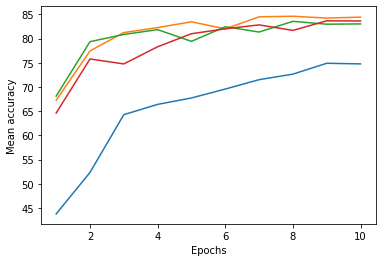

In [10]:
print(results.get_best_result())

ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results}
for d in dfs.values():
    ax = d.plot(ax=ax, y="mean_accuracy", x="epoch", legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")

## Hyperparameter optimization (ASAH Scheduler)

Now we are going to make the example slightly harder by integrating the ASAH scheduler. This scheduler will try to stop non-promising trials in order to save ressources. This allows us to choose a higher number of samples without increasing the training time. 

We can reuse the train_tune() function and the config from before. Afterwards we need to define the scheduler with the correct arguments. 

Now we only need to add the scheduler to the TuneConfig and afterwards we can start the HPO.

**HINT**: The ASAH scheduler can also take "metric" and "mode" as input. If you already defined this in the TuneConfig do **NOT** redefine it.

In [11]:
scheduler = ASHAScheduler(
    max_t=config["epochs"], # Max time per trial
    time_attr="training_iteration", # Which metric is used as measurement for "time"
    grace_period=3
    )

tuner = tune.Tuner(
    trainable,
    param_space = config,
    tune_config = tune.TuneConfig(
        metric = "mean_accuracy",
        mode = "max",
        num_samples = 8,
        scheduler=scheduler,
    )
)

results_asah = tuner.fit()

2023-01-12 14:10:45,866	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-01-12 14:10:46,041	WARNING util.py:244 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.
2023-01-12 14:10:49,624	WARNING util.py:244 -- The `start_trial` operation took 0.559 s, which may be a performance bottleneck.


Trial name,date,done,episodes_total,epoch,experiment_id,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_tune_832f6_00000,2023-01-12_14-11-57,True,,10,532593553aa543769028c6b60d02befe,fedora,10,64.2333,192.168.188.20,949896,68.9494,6.89415,68.9494,1673529117,0,,10,832f6_00000,0.00396371
train_tune_832f6_00001,2023-01-12_14-12-00,True,,10,7b5a72ba49b64d05a386ec4b32b22ec0,fedora,10,83.6917,192.168.188.20,949971,68.5876,6.9375,68.5876,1673529120,0,,10,832f6_00001,0.00386667
train_tune_832f6_00002,2023-01-12_14-11-11,True,,3,a57dc65588434a5ba7640f5c234caa3c,fedora,3,58.5917,192.168.188.20,949987,20.0996,6.79051,20.0996,1673529071,0,,3,832f6_00002,0.00404501
train_tune_832f6_00003,2023-01-12_14-12-01,True,,10,97c55abecf0a401eb4f3efbf69d75914,fedora,10,82.6417,192.168.188.20,950062,69.4632,6.96391,69.4632,1673529121,0,,10,832f6_00003,0.00477552
train_tune_832f6_00004,2023-01-12_14-11-33,True,,3,a57dc65588434a5ba7640f5c234caa3c,fedora,3,76.325,192.168.188.20,949987,21.1927,7.2114,21.1927,1673529093,0,,3,832f6_00004,0.00404501
train_tune_832f6_00005,2023-01-12_14-12-38,True,,10,a57dc65588434a5ba7640f5c234caa3c,fedora,10,85.2,192.168.188.20,949987,65.7014,6.13433,65.7014,1673529158,0,,10,832f6_00005,0.00404501
train_tune_832f6_00006,2023-01-12_14-12-17,True,,3,532593553aa543769028c6b60d02befe,fedora,3,79.2167,192.168.188.20,949896,20.4106,6.78374,20.4106,1673529137,0,,3,832f6_00006,0.00396371
train_tune_832f6_00007,2023-01-12_14-13-01,True,,10,7b5a72ba49b64d05a386ec4b32b22ec0,fedora,10,84.05,192.168.188.20,949971,61.2824,5.65888,61.2824,1673529181,0,,10,832f6_00007,0.00386667


2023-01-12 14:13:01,554	INFO tune.py:762 -- Total run time: 141.84 seconds (141.04 seconds for the tuning loop).


Result(metrics={'mean_accuracy': 85.2, 'epoch': 10, 'done': True, 'trial_id': '832f6_00005', 'experiment_tag': '5_lr=0.0691,weight_decay=0.0001'}, error=None, log_dir=PosixPath('/home/raffi/ray_results/train_tune_2023-01-12_14-10-39/train_tune_832f6_00005_5_lr=0.0691,weight_decay=0.0001_2023-01-12_14-11-33'))


Text(0, 0.5, 'Mean accuracy')

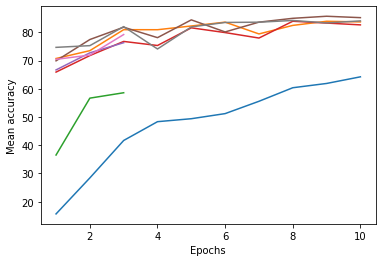

In [12]:
print(results_asah.get_best_result())

ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results_asah}
for d in dfs.values():
    ax = d.plot(ax=ax, y="mean_accuracy", x="epoch", legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")

In the graph we can see that indeed trials were stopped by ASAH.

## Hyperparameter optimization (PBT)

![tune_pbt_600px.png](images/tune_pbt_600px.png)

*Ray Framework Overview (https://docs.ray.io/en/latest/index.html)*

One of the most interesting HPO algorithms in Ray Tune is the Population Based Training (PBT). In PBT we do not see each trial as independent but we rather try to increase the performance of the whole population of trials. After some epochs PBT will replace bad performing trials with good performing ones and perturb their parameters. Similar to the ASAH scheduler this will ensure that non-promising trials are stopped early on and that the search focuses on the promising parts in the search space. 

Ray Tune contains a distributed implementation of this algorithm. Since PBT will replace the bad with the good trials we need to somehow store the state of the good trials. This can be achieved by using checkpoints in Ray. The code below shows the modified train_tune() function.

Let's first look at the added lines in the training loop. We first create a folder for the checkpoint with os.makedirs(). Afterwards we use the torch.save() function to store the models parameters and the current epoch. We can now create a checkpoint by using the Checkpoint.from_directory() function. This checkpoint can be added to the session.report() function which we already used before. Now a checkpoint containing the model's state will be created in each iteration. For large epoch number the checkpoint frequency should be lower to avoid unnecessary overhead.

If a bad trial is stopped Tune will create a new trial and run the training function with the perturbed hyperparameters. It will furthermore copy the checkpoint of the better performing trial. Therefore we need to check whether a checkpoint is available at the beginning of the training. If there is no checkpoint available we now that this trial is new and was not replace. If there is a checkpoint available then the trial was replaced and we need to load the state of the model. Furthermore we need to set the current epoch to the correct value.

In [13]:
def train_tune_pbt(config):
    step = 0
    epochs = config["epochs"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = NeuralNetwork().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    if session.get_checkpoint():
        loaded_checkpoint = session.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            path = os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            checkpoint = torch.load(path)
            model.load_state_dict(checkpoint["model_state"])
            step = checkpoint["last_step"] + 1

    for t in range(step, epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_epoch(train_dataloader, model, loss_fn, optimizer, device)
        accuracy = test(val_dataloader, model, loss_fn, device)

        os.makedirs("model", exist_ok=True)
        torch.save(
            {
                "last_step": t,
                "model_state": model.state_dict(),
            },
            "model/checkpoint.pt"
        )
        checkpoint = Checkpoint.from_directory("model")
        session.report(metrics={"mean_accuracy": accuracy, "step": t}, checkpoint=checkpoint)

Now the process is similar to the examples before. We create a trainable function and assign the needed ressources. Instead of defining the ASAH scheduler as before we define the PBT scheduler and the tuner is created and started as done before.

**HINT**: The PBT scheduler can also take "metric" and "mode" as input. If you already defined this in the TuneConfig do **NOT** redefine it.

In [14]:
# Define resources for each trial
resources = {"cpu":4, "gpu":1} if torch.cuda.is_available() else {"cpu":4}
trainable = tune.with_resources(train_tune_pbt, resources=resources) 

# Define the PBT algorithm
scheduler = PopulationBasedTraining(
    time_attr = "training_iteration",
    perturbation_interval = 2,
    hyperparam_mutations = {
        "lr": tune.uniform(1e-1,1e-5),
        "weight_decay": tune.uniform(1e-2,1e-6)
    },
)

# Create the HPO tuner
tuner = tune.Tuner(
    trainable,
    param_space = config,
    tune_config = tune.TuneConfig(
        metric = "mean_accuracy",
        mode = "max",
        num_samples = 4,
        scheduler=scheduler,
    )
)

# Run the tuner
results_pbt = tuner.fit()

2023-01-12 14:13:03,163	WARNING trial_runner.py:1700 -- You are trying to access _search_alg interface of TrialRunner in TrialScheduler, which is being restricted. If you believe it is reasonable for your scheduler to access this TrialRunner API, please reach out to Ray team on GitHub. A more strict API access pattern would be enforced starting 1.12s.0
2023-01-12 14:13:05,468	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (45 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-01-12 14:13:05,957	WARNING util.py:244 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,should_checkpoint,step,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_tune_pbt_d7fc6_00000,2023-01-12_14-14-16,True,,87a1622fe0164817b5faa4fe71e3881d,"0_lr=0.0851,weight_decay=0.0002",fedora,10,86.4167,192.168.188.20,950353,True,9,68.6753,7.40603,68.6753,1673529256,0,,10,d7fc6_00000,0.00411963
train_tune_pbt_d7fc6_00001,2023-01-12_14-14-25,True,,87a1622fe0164817b5faa4fe71e3881d,"1_lr=0.0373,weight_decay=0.0095@perturbed[lr=0.1021,weight_decay=0.0001]",fedora,2,85.7583,192.168.188.20,950837,True,9,12.9206,5.95308,67.3232,1673529265,0,,10,d7fc6_00001,0.011462
train_tune_pbt_d7fc6_00002,2023-01-12_14-14-19,True,,68444dfd7c0f4657aefce46cfc92d01c,"2_lr=0.0574,weight_decay=0.0076",fedora,10,84.0667,192.168.188.20,950455,True,9,68.037,6.97279,68.037,1673529259,0,,10,d7fc6_00002,0.00395679
train_tune_pbt_d7fc6_00003,2023-01-12_14-14-20,True,,33b8798c0447495ab583b4174f7bedbf,"3_lr=0.0485,weight_decay=0.0007",fedora,10,84.7583,192.168.188.20,950529,True,9,68.3522,6.86596,68.3522,1673529260,0,,10,d7fc6_00003,0.00353909


2023-01-12 14:13:24,531	INFO pbt.py:646 -- [pbt]: no checkpoint for trial. Skip exploit for Trial train_tune_pbt_d7fc6_00001
2023-01-12 14:13:51,692	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial d7fc6_00002 (score = 81.983333) into trial d7fc6_00001 (score = 79.683333)

2023-01-12 14:13:51,693	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triald7fc6_00001:
lr : 0.057402413531362585 --- (* 1.2) --> 0.0688828962376351
weight_decay : 0.0076141487080753365 --- (* 1.2) --> 0.009136978449690403

2023-01-12 14:14:08,779	INFO pbt.py:804 -- 

[PopulationBasedTraining] [Exploit] Cloning trial d7fc6_00000 (score = 85.450000) into trial d7fc6_00001 (score = 83.541667)

2023-01-12 14:14:08,780	INFO pbt.py:831 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of triald7fc6_00001:
lr : 0.0850924209836303 --- (* 1.2) --> 0.10211090518035636
weight_decay : 0.0001677225707669306 --- (* 0.8) --> 0.000134

Result(metrics={'mean_accuracy': 86.41666666666666, 'step': 9, 'should_checkpoint': True, 'done': True, 'trial_id': 'd7fc6_00000', 'experiment_tag': '0_lr=0.0851,weight_decay=0.0002'}, error=None, log_dir=PosixPath('/home/raffi/ray_results/train_tune_pbt_2023-01-12_14-13-01/train_tune_pbt_d7fc6_00000_0_lr=0.0851,weight_decay=0.0002_2023-01-12_14-13-04'))


Text(0, 0.5, 'Mean accuracy')

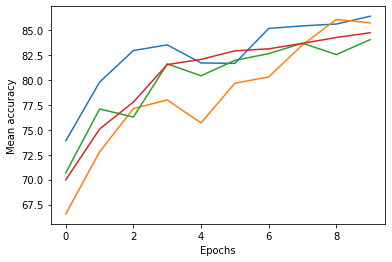

In [15]:
print(results_pbt.get_best_result())

ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results_pbt}
for d in dfs.values():
    ax = d.plot(ax=ax, y="mean_accuracy", x="step", legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")